In [14]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

from util import utils as data_utils

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

json_file = './results/simple_model/checkpoint_50.json'
FDIR = os.path.dirname(json_file)
NUM_CLASSIFY = 10

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Plot gradients norms for the entire learning process
grads_json_filename = os.path.join(FDIR, 'model_grads.json')
grads = [[], [], []]
grads_key = ['max_grad_w1_16', 'max_grad_w1_32', 'max_grad_w1_64']
if os.path.exists(grads_json_filename):
    with open(grads_json_filename, 'r') as fp:
        data = json.load(fp)
        for i, k in enumerate(grads_key):
            if data[0].get(k, None) is None:
                continue
            for batch_grads in data:
                grads[i].append(batch_grads[k])

def plot_grads(grads, title, x_label, y_label, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    # plt.subplot(2, 1, 1)
    plt.plot(grads)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
for i, g in enumerate(grads):
    if len(g) > 0:
        plot_grads(g, grads_key[i], 'iterations', grads_key[i])
        # pass

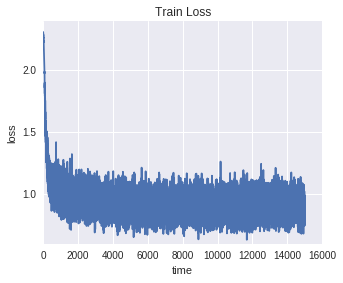

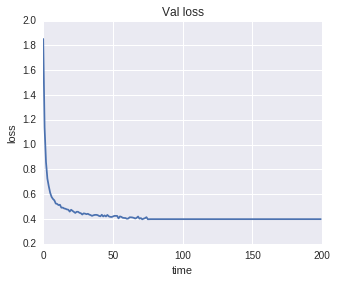

In [16]:
with open(json_file, 'r') as fp:
    data = json.load(fp)
# Loss history might not be of equal length.
train_loss_hist = data['train_loss_history']
val_loss_hist = data['val_loss_history']

# pdb.set_trace()
def plot_loss_hist(loss_hist, title,):
    plt.figure(figsize=(5,4))
    plt.subplot(1, 1, 1)
    plt.plot(loss_hist)
    plt.title(title)  # Train Loss
    plt.ylabel('loss')
    plt.xlabel('time')
    plt.show()
    
plot_loss_hist(train_loss_hist, 'Train Loss')
plot_loss_hist(val_loss_hist, 'Val loss')

if data.get('crit1_loss_history', None) is not None:
    plot_loss_hist(data['crit1_loss_history'], 'Target criterion loss')

if data.get('crit2_loss_history', None) is not None:
    plot_loss_hist(data['crit2_loss_history'], 'Pred criterion loss')

if data.get('pred_loss_history', None) is not None:
    plot_loss_hist(data['pred_loss_history'], 'Total Pred loss (beta*t + (1-beta)*p)')    

if data.get('beta_loss_history', None) is not None:
    plot_loss_hist(data['beta_loss_history'], 'Beta loss')

In [17]:
if data.get('KL_loss_history', None) is not None:
    # Loss history might not be of equal length.
    KL_loss_hist = data['KL_loss_history']

    plt.figure(figsize=(10,8))
    plt.plot(KL_loss_hist)
    plt.title('KL loss')
    plt.ylabel('loss')
    plt.xlabel('time')
    plt.show()

In [18]:
def get_conf(json_file, num_classes=26, json_key='conf'):
    with open(json_file, 'r') as fp:
        data = json.load(fp)
        conf = data.get(json_key, None)
    if conf is None:
        return
    # c1 = conf.split('\n')[1].split("]")[0].split("[ ")[1].split(" ")
    c1 = conf.split('\n')
    # print(c1)
    conf_mat, row_idx = np.zeros((num_classes, num_classes)), 0
    for i in c1:
        #pdb.set_trace()
        is_conf_row = False
        if ']' in i and '[[' in i:
            val = i.split(']')[0].split('[[')[1].split(' ')
            is_conf_row = True
        elif ']' in i and '[' in i:
            val = i.split(']')[0].split('[')[1].split(' ')
            is_conf_row = True
        if is_conf_row:
            col_idx = 0
            for v in val:
                if not len(v):
                    continue
                try:
                    conf_mat[row_idx, col_idx] = int(v)
                    col_idx = col_idx + 1
                except:
                    continue
            row_idx = row_idx + 1
    
    assert(row_idx == num_classes)
    conf_mat = conf_mat.astype(int)
    fdir = os.path.dirname(json_file)
    json_name = os.path.basename(json_file)[:-5]
    conf_file_name = fdir + '/' + 'conf_' + json_name + '.txt'
    np.savetxt(conf_file_name, conf_mat, fmt='%d', delimiter=', ')
    return conf_mat


def plot_conf(norm_conf):
  # Plot using seaborn
  # (this is style I used for ResNet matrix)
  plt.figure(figsize=(5,4))
  df_cm = pd.DataFrame(norm_conf)
  sns.heatmap(df_cm, annot=True, cmap="Blues")
  plt.show()

In [19]:
def get_sorted_checkpoints(fdir):
    # Checkpoint files are named as 'checkpoint_%d.json'
    checkpoint_map = {}
    for f in os.listdir(fdir):
        if f.endswith('json') and f.startswith('checkpoint'):
            checkpoint_num = int(f.split('checkpoint_')[-1].split('.')[0])
            checkpoint_map[checkpoint_num] = f
    sorted_checkpoints = []
    for k in sorted(checkpoint_map.keys()):
        v = checkpoint_map[k]
        sorted_checkpoints.append(v)
    return sorted_checkpoints

In [20]:
def best_f_scores(fdir, num_classes=5): 
    best_checkpoints = [None, None, None]
    best_3_fscores = [0, 0, 0]
    best_confs = [np.array(()), np.array(()), np.array(())]
    f1_weight_list = [1.0] * num_classes
    f1_weights = np.array(f1_weight_list)
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    for f in sorted_checkpoint_files:
        json_file = fdir + '/' + f
        conf = get_conf(json_file, num_classes, json_key='val_conf')
        norm_conf = data_utils.normalize_conf(conf)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
                f, f1, kappa, wt_f1))
        plot_conf(norm_conf)
        max_idx = -1
        for i in range(len(best_3_fscores)):
            if best_3_fscores[i] > f1:
                break
            max_idx = i
        for j in range(max_idx):
            best_3_fscores[j] = best_3_fscores[j+1]
            best_confs[j] = best_confs[j+1]
            best_checkpoints[j] = best_checkpoints[j+1]

        best_3_fscores[max_idx] = f1
        best_confs[max_idx] = conf
        best_checkpoints[max_idx] = f

    return best_3_fscores, best_confs, best_checkpoints

[[211899   2889   2989   1998   2545   2850   3499   2166   2956   5009]
 [  2404 244462   4196   2185   2320   2940   2405  62757   2430   3301]
 [  2850   3693 208652   2487   2784  56490   2876   3940   3596   3682]
 [  1962   3446   4415 183040   2585   4226   3311   3186  88921   3708]
 [  3522   3272   2869   2424 207234   2098   4175   3586   2115  63955]
 [  2954   3086  61988   3114   2423 192201  33342   2828   3132   3882]
 [  2312   2778   2076   1622   2554   3818 236461   2446   2710   3073]
 [  2186  67717   4408   2071   3450   2753   2638 222666   2717   5644]
 [  2981   3617   4043  95930   1734   5681   2946   2907 179360   4851]
 [ 60426   3277   2379   2785  59514   2766   2579   4030   3136 216708]]
file: <built-in method f of mtrand.RandomState object at 0x7ff2c3d565f0>, f1: 0.703, kappa: 0.549, weighted-F1: 0.698


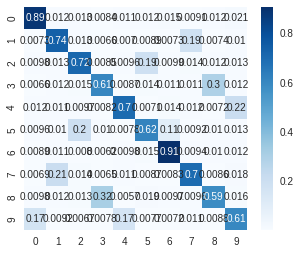

In [21]:
def plot_train_conf(fdir, num_classes=5):
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    if len(sorted_checkpoint_files) > 0:
        last_checkpoint = sorted_checkpoint_files[-1]
        json_file = fdir + '/' + last_checkpoint
        conf = get_conf(json_file, num_classes=num_classes, json_key='train_conf')
        print(conf)
        norm_conf = data_utils.normalize_conf(conf)
        f1_weight_list = [1.0] * num_classes
        f1_weights = np.array(f1_weight_list)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
            f, f1, kappa, wt_f1))
        plot_conf(norm_conf)

plot_train_conf(FDIR, num_classes=NUM_CLASSIFY)

file: checkpoint_1.json, f1: 0.880, kappa: 0.878, weighted-F1: 0.882


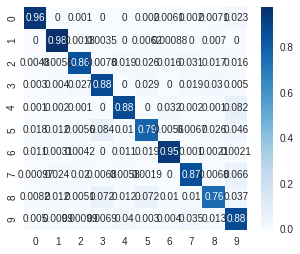

file: checkpoint_2.json, f1: 0.925, kappa: 0.920, weighted-F1: 0.926


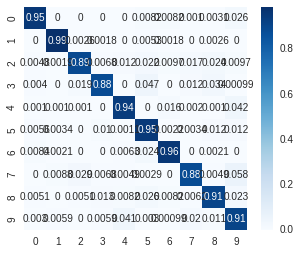

file: checkpoint_3.json, f1: 0.945, kappa: 0.942, weighted-F1: 0.945


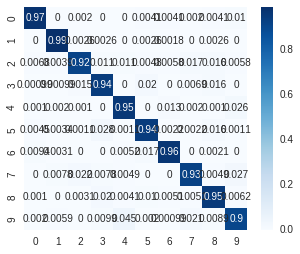

file: checkpoint_4.json, f1: 0.953, kappa: 0.947, weighted-F1: 0.953


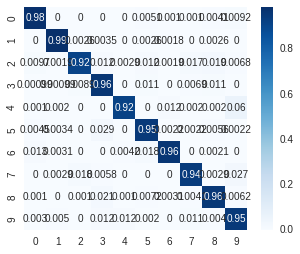

file: checkpoint_5.json, f1: 0.961, kappa: 0.955, weighted-F1: 0.961


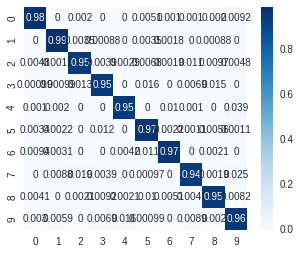

file: checkpoint_6.json, f1: 0.967, kappa: 0.962, weighted-F1: 0.967


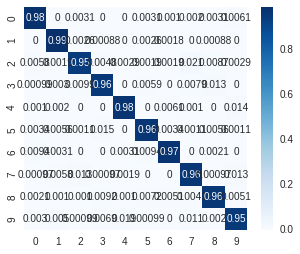

file: checkpoint_7.json, f1: 0.969, kappa: 0.963, weighted-F1: 0.969


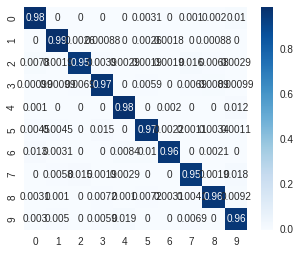

file: checkpoint_8.json, f1: 0.971, kappa: 0.963, weighted-F1: 0.972


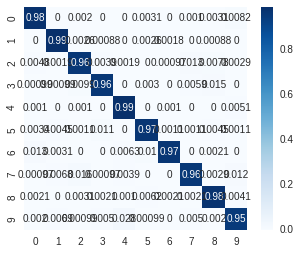

file: checkpoint_9.json, f1: 0.974, kappa: 0.967, weighted-F1: 0.974


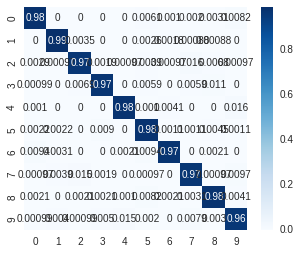

file: checkpoint_10.json, f1: 0.974, kappa: 0.969, weighted-F1: 0.975


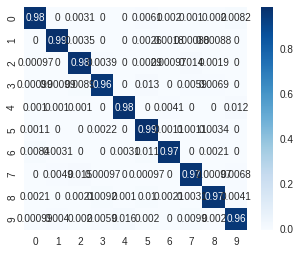

file: checkpoint_11.json, f1: 0.975, kappa: 0.970, weighted-F1: 0.976


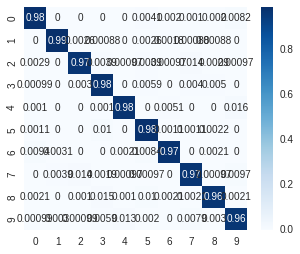

file: checkpoint_12.json, f1: 0.975, kappa: 0.968, weighted-F1: 0.975


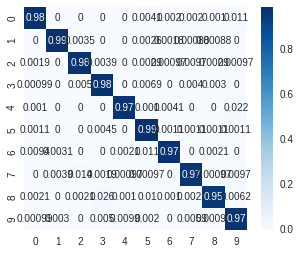

file: checkpoint_13.json, f1: 0.976, kappa: 0.968, weighted-F1: 0.976


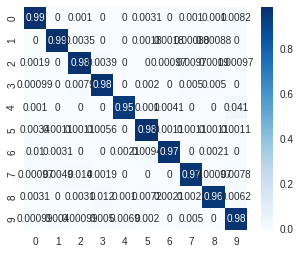

file: checkpoint_14.json, f1: 0.978, kappa: 0.972, weighted-F1: 0.978


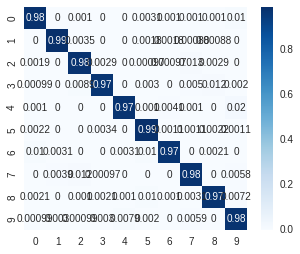

file: checkpoint_15.json, f1: 0.980, kappa: 0.973, weighted-F1: 0.980


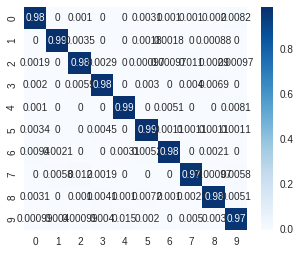

file: checkpoint_16.json, f1: 0.980, kappa: 0.973, weighted-F1: 0.980


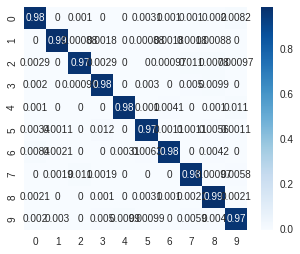

file: checkpoint_17.json, f1: 0.980, kappa: 0.974, weighted-F1: 0.980


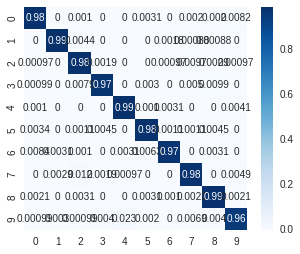

file: checkpoint_18.json, f1: 0.981, kappa: 0.974, weighted-F1: 0.981


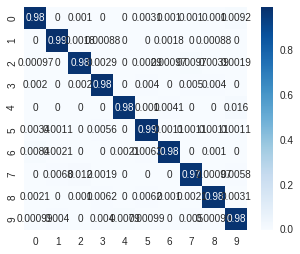

file: checkpoint_19.json, f1: 0.980, kappa: 0.974, weighted-F1: 0.980


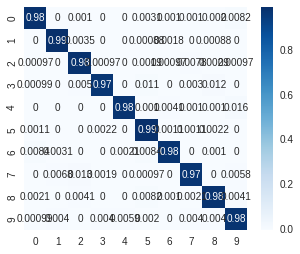

file: checkpoint_20.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


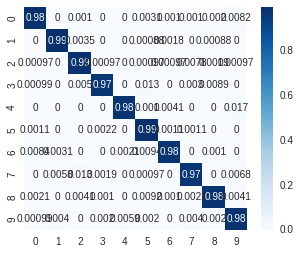

file: checkpoint_21.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


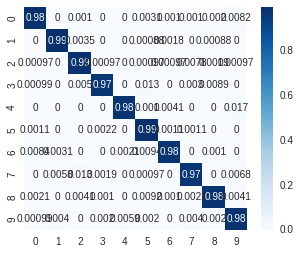

file: checkpoint_22.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


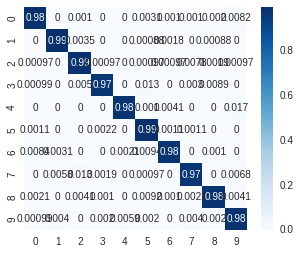

file: checkpoint_23.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


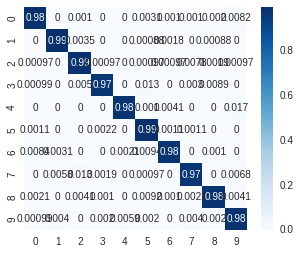

file: checkpoint_24.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


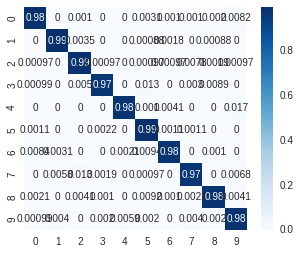

file: checkpoint_25.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


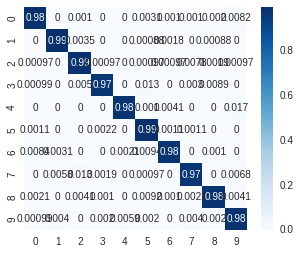

file: checkpoint_26.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


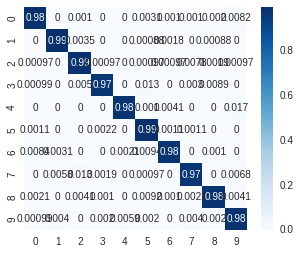

file: checkpoint_27.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


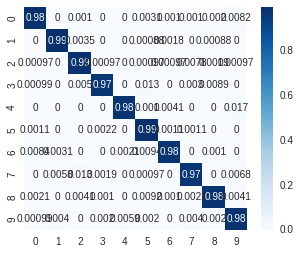

file: checkpoint_28.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


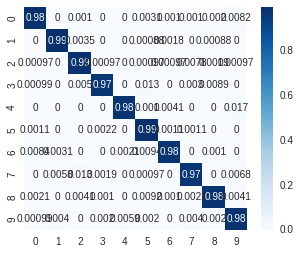

file: checkpoint_29.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


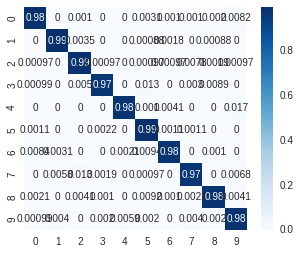

file: checkpoint_30.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


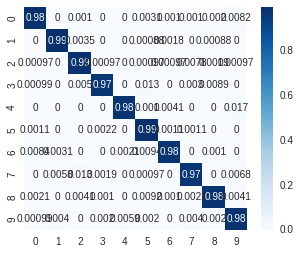

file: checkpoint_31.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


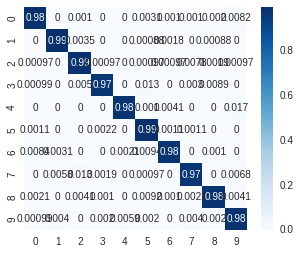

file: checkpoint_32.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


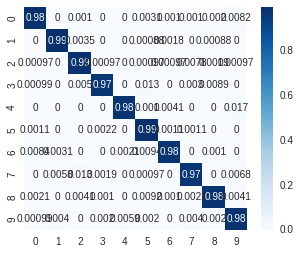

file: checkpoint_33.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


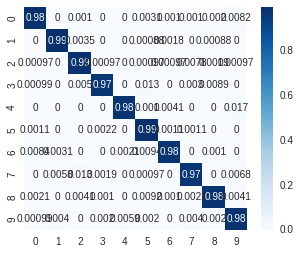

file: checkpoint_34.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


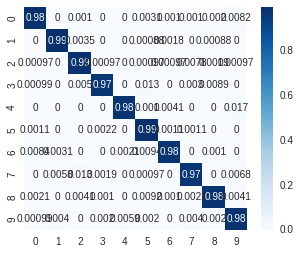

file: checkpoint_35.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


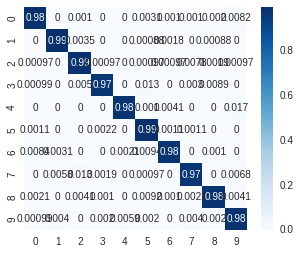

file: checkpoint_36.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


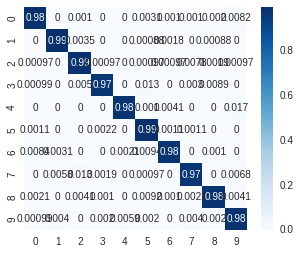

file: checkpoint_37.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


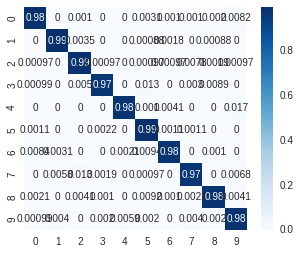

file: checkpoint_38.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


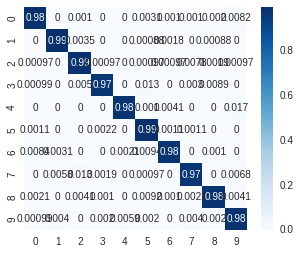

file: checkpoint_39.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


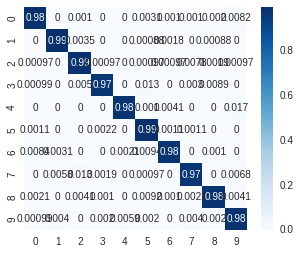

file: checkpoint_40.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


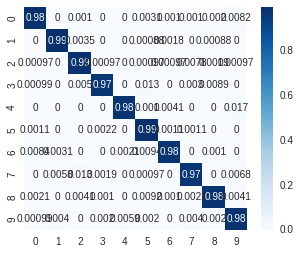

file: checkpoint_41.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


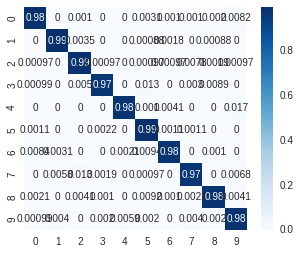

file: checkpoint_42.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


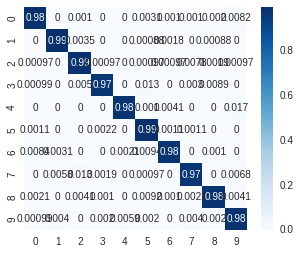

file: checkpoint_43.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


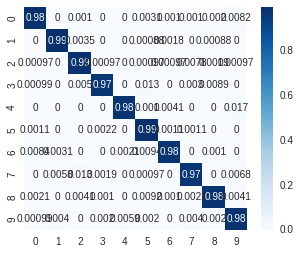

file: checkpoint_44.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


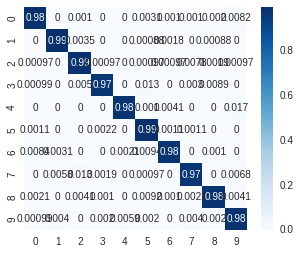

file: checkpoint_45.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


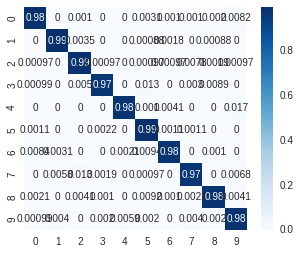

file: checkpoint_46.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


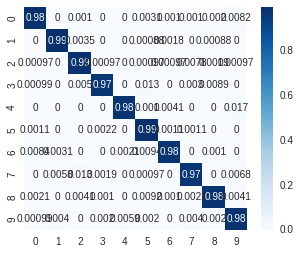

file: checkpoint_47.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


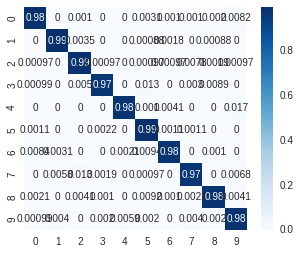

file: checkpoint_48.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


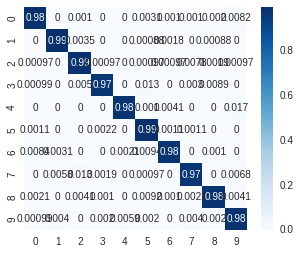

file: checkpoint_49.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


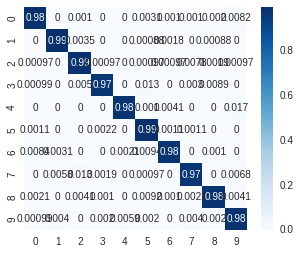

file: checkpoint_50.json, f1: 0.981, kappa: 0.975, weighted-F1: 0.981


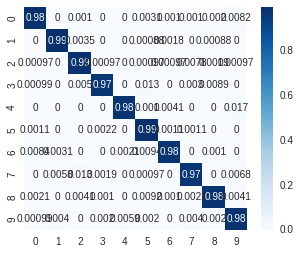

([0.98056494688941331, 0.98056494688941331, 0.98101088534719594],
 [array([[ 964,    0,    1,    0,    0,    3,    1,    1,    2,    8],
         [   0, 1127,    4,    0,    0,    1,    2,    0,    1,    0],
         [   1,    0, 1017,    1,    0,    1,    1,    8,    2,    1],
         [   1,    0,    5,  979,    0,   13,    0,    3,    9,    0],
         [   0,    0,    0,    0,  960,    1,    4,    0,    0,   17],
         [   1,    0,    0,    2,    0,  887,    1,    1,    0,    0],
         [   8,    3,    0,    0,    2,    9,  935,    0,    1,    0],
         [   0,    6,   13,    2,    0,    1,    0,  999,    0,    7],
         [   2,    0,    4,    1,    0,    9,    1,    2,  951,    4],
         [   1,    4,    0,    2,    6,    2,    0,    4,    2,  988]]),
  array([[ 964,    0,    1,    0,    0,    3,    1,    1,    2,    8],
         [   0, 1127,    4,    0,    0,    1,    2,    0,    1,    0],
         [   1,    0, 1017,    1,    0,    1,    1,    8,    2,    1],
         

In [22]:
best_f_scores(FDIR, num_classes=NUM_CLASSIFY)